In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from childes_mi.utils.paths import CHILDES_DFS, DATA_DIR
from childes_mi.utils.general import flatten

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm.autonotebook import tqdm

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [4]:
transcript_df = pd.read_pickle(CHILDES_DFS/'childes_df.pickle')
#transcript_df['dataset'] = [i[0].split('/')[11] for i in transcript_df.transcript_xml.values]
len(transcript_df)

123175

In [5]:
# mask for only a subset of corpuses
possible_corpuses = [
    # carterette is also transcribed in IPA
    "Carterette",  # 1st, 3rd, 5th grade, adults, speech naturalistic speech in IPA https://childes.talkbank.org/access/Eng-NA/Carterette.html
    "Gillam",  # normal subset, spontaneous storytelling 5-11y11m https://childes.talkbank.org/access/Clinical-MOR/Gillam.html
    "Braunwald",  # single subject from 1-6yo talking to family https://childes.talkbank.org/access/Eng-NA/Braunwald.html
    "Brown",  # 1y6m-5y1m, 3 subjects naturalistic talking to parents https://childes.talkbank.org/access/Eng-NA/Brown.html
    "EllisWeismer",  # 2y6m - 5y6 naturalistic play-oriented talk with instructor # https://childes.talkbank.org/access/Clinical-MOR/EllisWeismer.html
    "Gleason",  # 2;1 - 5;2 family interactions https://childes.talkbank.org/access/Eng-NA/Gleason.html
    "NH",# Nicholas-NH,  # 1;0-4;0, videotaped play with parent https://childes.talkbank.org/access/Clinical-MOR/Nicholas/NH.html
    "Post",  # 1;7-2;8 60m session with family and toys https://childes.talkbank.org/access/Eng-NA/Post.html
    "Normal",  #  Rondal-Normal 3-12yo free play with mother and child https://childes.talkbank.org/access/Clinical-MOR/Normal /Normal.html
]
corpus_mask = [corpus in possible_corpuses for corpus in transcript_df.corpus.values]
transcript_df = transcript_df[corpus_mask]

In [6]:
# mask for a subset of roles
possible_roles = ['Target_Child', 'Child']
role_mask = [role in possible_roles for role in transcript_df.role.values]
transcript_df = transcript_df[role_mask]
len(transcript_df)

2785

In [7]:
transcript_df[:3]

,PID,lang,corpus,date,participant_key,role,age,language,sex,POS,words,morphemes,transcript_xml,n_words,n_morphemes,n_POS
72301,11312/c-00015848-1,eng,Carterette,1984-01-01,CHI,Target_Child,P6Y,eng,NaN,"[[pro:per, v, , , conj, n:prop, coord, pro:ind...","[[you, mean, uh, um, like, England, or, someth...","[[you, mean, uh, um, like, England, or, someth...",[/mnt/cube/tsainbur/Projects/github_repos/chil...,2102,2102,2102
72302,11312/c-00015847-1,eng,Carterette,1984-01-01,CHI,Target_Child,P10Y,eng,NaN,"[[co, , pro:sub, v, , det:num, n], [coord, , p...","[[well, um, I, have, uh, one, sister], [and, u...","[[well, um, I, have, uh, one, sister], [and, u...",[/mnt/cube/tsainbur/Projects/github_repos/chil...,2729,2729,2729
72303,11312/c-00015849-1,eng,Carterette,1984-01-01,CHI,Target_Child,P8Y,eng,NaN,"[[v, n, n], [co, n:prop, v, prep, det:art, n, ...","[[lets, watch, tv], [well, Nancy, said, for, t...","[[let-3S, watch, tv], [well, Nancy, say-PAST, ...",[/mnt/cube/tsainbur/Projects/github_repos/chil...,2019,2019,2019


In [22]:
transcript_df.iloc[0]

PID                                               11312/c-00015848-1
lang                                                             eng
corpus                                                    Carterette
date                                                      1984-01-01
participant_key                                                  CHI
role                                                    Target_Child
age                                                              P6Y
language                                                         eng
sex                                                              NaN
POS                [[pro:per, v, , , conj, n:prop, coord, pro:ind...
words              [[you, mean, uh, um, like, England, or, someth...
morphemes          [[you, mean, uh, um, like, England, or, someth...
transcript_xml     [/mnt/cube/tsainbur/Projects/github_repos/chil...
n_words                                                        19903
n_morphemes                       

In [9]:
transcript_df['n_words'] = [len(np.concatenate(i)) if len(i) > 0 else 0 for i in transcript_df.words.values]

In [10]:
print(transcript_df.corpus.unique())

['Carterette' 'Brown' 'Braunwald' 'Post' 'Gleason' 'Normal' 'Gillam'
 'EllisWeismer' 'NH']


In [11]:
print("there are {} words in this dataset".format(np.sum(transcript_df.n_words.values)))

there are 1247296 words in this dataset


### Get child ages

In [12]:
import re
def convert_age(age_year):
    "Caclculate age in months from a string in CHILDES format"
    if age_year[-1] == 'Y':
        age_year += '0'
    m = re.match("P(\d+)Y(\d+)M?(\d?\d?)D?", age_year)
    age_month = int(m.group(1)) * 12 + int(m.group(2))
    try:
        if int(m.group(3)) > 15:
            age_month += 1
    # some corpora don't have age information?
    except ValueError as e:
        pass
    return age_month

In [13]:
transcript_df["age_months"] = [
    convert_age(i) if type(i) == str else np.nan for i in tqdm(transcript_df.age.values)
]

In [14]:
transcript_df["age_years"] = transcript_df["age_months"] / 12

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/numpy/lib/histograms.py:754: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/numpy/lib/histograms.py:755: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


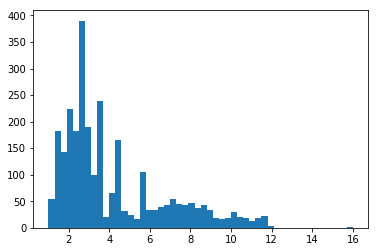

In [15]:
plt.hist(transcript_df.age_years.values, bins = 50);

In [16]:
transcript_df[:3]

,PID,lang,corpus,date,participant_key,role,age,language,sex,POS,words,morphemes,transcript_xml,n_words,n_morphemes,n_POS,age_months,age_years
72301,11312/c-00015848-1,eng,Carterette,1984-01-01,CHI,Target_Child,P6Y,eng,NaN,"[[pro:per, v, , , conj, n:prop, coord, pro:ind...","[[you, mean, uh, um, like, England, or, someth...","[[you, mean, uh, um, like, England, or, someth...",[/mnt/cube/tsainbur/Projects/github_repos/chil...,19903,2102,2102,72.0,6.0
72302,11312/c-00015847-1,eng,Carterette,1984-01-01,CHI,Target_Child,P10Y,eng,NaN,"[[co, , pro:sub, v, , det:num, n], [coord, , p...","[[well, um, I, have, uh, one, sister], [and, u...","[[well, um, I, have, uh, one, sister], [and, u...",[/mnt/cube/tsainbur/Projects/github_repos/chil...,26941,2729,2729,120.0,10.0
72303,11312/c-00015849-1,eng,Carterette,1984-01-01,CHI,Target_Child,P8Y,eng,NaN,"[[v, n, n], [co, n:prop, v, prep, det:art, n, ...","[[lets, watch, tv], [well, Nancy, said, for, t...","[[let-3S, watch, tv], [well, Nancy, say-PAST, ...",[/mnt/cube/tsainbur/Projects/github_repos/chil...,21419,2019,2019,96.0,8.0


/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


(0.8, 6)

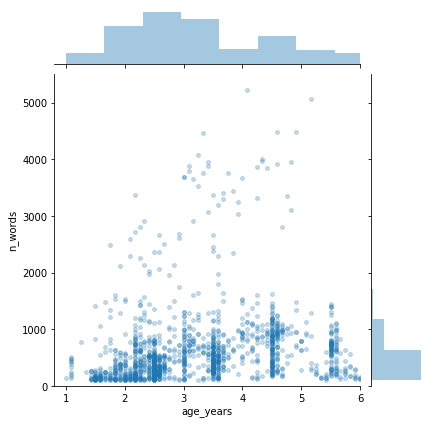

In [17]:
import seaborn as sns

grd = sns.jointplot(
    "age_years",
    "n_words",
    data=transcript_df[transcript_df.n_words > 100],
    alpha=0.25,
    s=15,
)
ax = grd.ax_joint
ax.set_ylim([0, 5500])
ax.set_xlim([0.8, 6])

In [18]:
import seaborn as sns
from childes_mi.utils.paths import DATA_DIR, FIGURE_DIR, ensure_dir
from childes_mi.utils.general import flatten,save_fig
ensure_dir(FIGURE_DIR/ 'distributions')

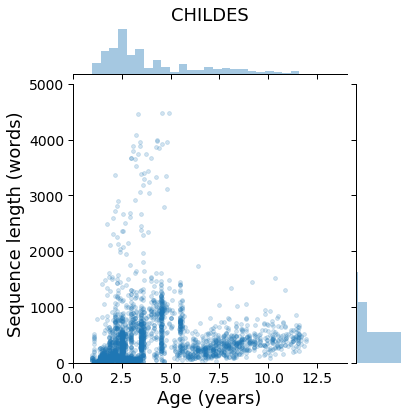

In [19]:
sns.set_context("paper", rc={"font.size":24,"axes.titlesize":18,"axes.labelsize":18, "axes.ticksize":14})   

p = sns.jointplot("age_years", "n_words", data=transcript_df, alpha=0.2, annot_kws={"size": 16}, s=15)

p.set_axis_labels(xlabel="Age (years)", ylabel="Sequence length (words)")
p.ax_joint.tick_params(labelsize=14)
p.ax_marg_x.set_title("CHILDES")
p.ax_joint.set_ylim([0,5000])
p.ax_joint.set_xlim([0,14])
save_fig(FIGURE_DIR/ 'distributions' / 'childes_distribution')
plt.show()

In [20]:
np.mean(transcript_df.n_words)

447.862118491921

### utterance lengths

In [21]:
# utterance_df = pd.DataFrame(columns = ['age_years', 'utterance_length'])
utterance_df = pd.DataFrame(
    [
        [row.age_years, len(i)]
        for idx, row in tqdm(transcript_df.iterrows(), total=len(transcript_df))
        for i in row.words
    ],
    columns=["age_years", "utterance_length"],
)

In [23]:
len(utterance_df)

341548

In [24]:
utterance_df[:3]

,age_years,sentence_length
0,6.0,8
1,6.0,12
2,6.0,9


(0.8, 6)

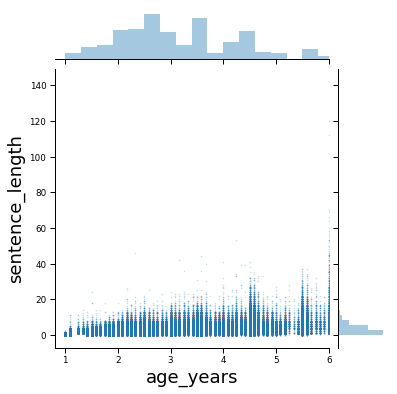

In [25]:
import seaborn as sns

grd = sns.jointplot(
    "age_years",
    "utterance_length",
    data=utterance_df,
    alpha=0.15,
    s=1,
    #kind="hex"
)
ax = grd.ax_joint
#ax.set_ylim([0, 1500])
ax.set_xlim([0.8, 6])

### dataset statistics

In [26]:
age_cohorts = [[1, 1.5], [1.5, 2], [2, 2.5], [2.5, 3], [3, 20]]

In [27]:

for (age_cohort_low, age_cohort_high) in tqdm(age_cohorts):
    
    cohort_subset = transcript_df[
        (transcript_df.age_months/12 > age_cohort_low) & (transcript_df.age_months/12 <= age_cohort_high)
    ]
    
    cohort_words = [[i for i in list(flatten(row.words)) if i not in [None, 'xxx']] for idx, row in cohort_subset.iterrows()]
    
    n_words = len(np.concatenate(cohort_words))
    n_unique_words = len(np.unique(np.concatenate(cohort_words)))
    
    print(age_cohort_low, age_cohort_high, np.median([len(i) for i in cohort_words]), n_words, n_unique_words)
    #plt.hist([len(i) for i in cohort_words])
    #plt.show()

1 1.5 38.0 15154 1239
1.5 2 98.0 57580 3199
2 2.5 204.0 167722 5363
2.5 3 121.5 110580 4995
3 20 394.0 855307 14410



## MI
- for each sequence, calculate the decay of a sequence as a function of distance between elements for that sequence indiividually
- Treat each phoneme as unique for that child, and compute MI across children

In [28]:
from childes_mi.information_theory import mutual_information as mi

#### Run MI by age cohort

In [29]:
distances = np.arange(1,101)

In [30]:
def remove_repeats(sequence):
    if len(sequence) == 0:
        return sequence
    a = np.array(sequence[1:])
    b = np.array(sequence[:-1])
    c = [sequence[0]] + list(a[a != b])
    return c

['more', 'cookie', 'more', 'cookie', 'more']
['qn', 'n', 'qn', 'n', 'qn']
['more', 'cookie', 'cookie', 'more', 'juice']
['Mommy', 'stair', '', 'a', 'that']


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done  74 out of 100 | elapsed:    4.6s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done  95 out of 100 | elapsed:    5.2s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    5.3s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done  74 out of 100 | elapsed:    5.8s remaining:    2.0s
[Parallel(n_jobs=-1)]: Done  95 out of 100 | elapsed:    5.9s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    5.9s finished


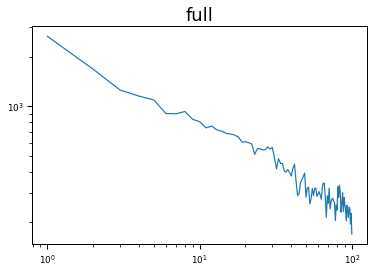

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done  74 out of 100 | elapsed:    4.6s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done  95 out of 100 | elapsed:    5.1s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    5.2s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done  74 out of 100 | elapsed:    5.6s remaining:    2.0s
[Parallel(n_jobs=-1)]: Done  95 out of 100 | elapsed:    5.6s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    5.6s finished


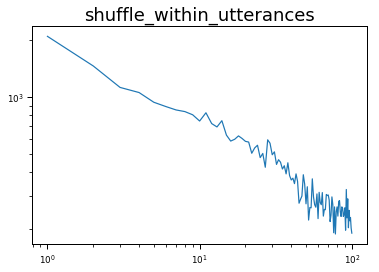

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done  74 out of 100 | elapsed:    4.8s remaining:    1.7s
[Parallel(n_jobs=-1)]: Done  95 out of 100 | elapsed:    5.5s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    5.6s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done  74 out of 100 | elapsed:    5.8s remaining:    2.0s
[Parallel(n_jobs=-1)]: Done  95 out of 100 | elapsed:    5.8s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    5.9s finished


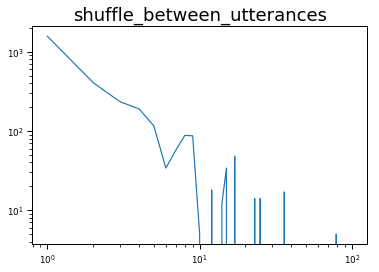

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done  74 out of 100 | elapsed:    3.8s remaining:    1.3s
[Parallel(n_jobs=-1)]: Done  95 out of 100 | elapsed:    4.4s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    4.5s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done  74 out of 100 | elapsed:    4.9s remaining:    1.7s
[Parallel(n_jobs=-1)]: Done  95 out of 100 | elapsed:    4.9s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    4.9s finished


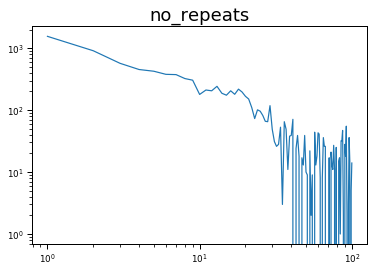

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  74 out of 100 | elapsed:    1.7s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  95 out of 100 | elapsed:    1.9s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.0s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done  74 out of 100 | elapsed:    2.5s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done  95 out of 100 | elapsed:    2.5s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.5s finished


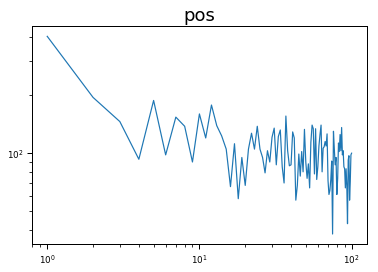

['peep', 'peep', 'yeah', 'blocks', 'one']
['on', 'co', 'n', 'det:num', 'det:num']
['peep', 'peep', 'yeah', 'blocks', 'one']
['Mommy', 'turn', 'the', 'page', 'that']


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done  74 out of 100 | elapsed:   22.1s remaining:    7.8s
[Parallel(n_jobs=-1)]: Done  95 out of 100 | elapsed:   23.1s remaining:    1.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   23.8s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   17.7s
[Parallel(n_jobs=-1)]: Done  74 out of 100 | elapsed:   23.5s remaining:    8.3s
[Parallel(n_jobs=-1)]: Done  95 out of 100 | elapsed:   23.5s remaining:    1.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   24.0s finished


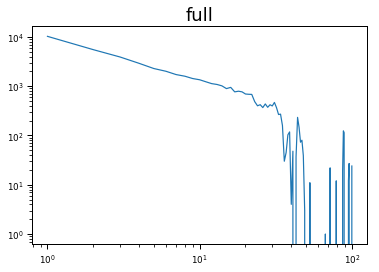

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done  74 out of 100 | elapsed:   22.7s remaining:    8.0s
[Parallel(n_jobs=-1)]: Done  95 out of 100 | elapsed:   24.5s remaining:    1.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   25.1s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   17.5s
[Parallel(n_jobs=-1)]: Done  74 out of 100 | elapsed:   23.2s remaining:    8.2s
[Parallel(n_jobs=-1)]: Done  95 out of 100 | elapsed:   23.2s remaining:    1.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   23.7s finished


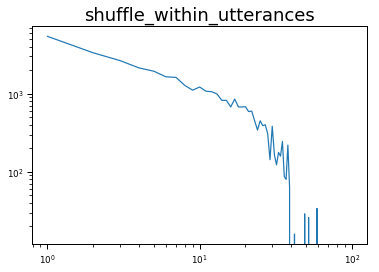

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    8.5s
[Parallel(n_jobs=-1)]: Done  74 out of 100 | elapsed:   25.0s remaining:    8.8s
[Parallel(n_jobs=-1)]: Done  95 out of 100 | elapsed:   26.8s remaining:    1.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   27.4s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   16.2s
[Parallel(n_jobs=-1)]: Done  74 out of 100 | elapsed:   21.6s remaining:    7.6s
[Parallel(n_jobs=-1)]: Done  95 out of 100 | elapsed:   21.6s remaining:    1.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   21.9s finished


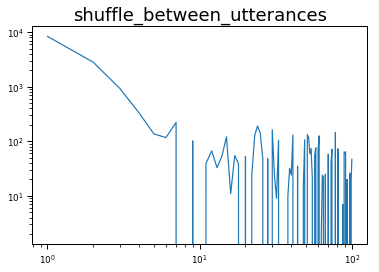

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done  74 out of 100 | elapsed:   22.5s remaining:    7.9s
[Parallel(n_jobs=-1)]: Done  95 out of 100 | elapsed:   23.8s remaining:    1.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   24.4s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   16.8s
[Parallel(n_jobs=-1)]: Done  74 out of 100 | elapsed:   22.1s remaining:    7.8s
[Parallel(n_jobs=-1)]: Done  95 out of 100 | elapsed:   22.1s remaining:    1.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   22.6s finished


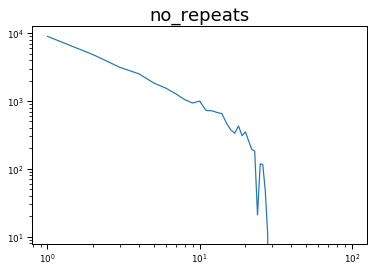

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done  74 out of 100 | elapsed:    8.1s remaining:    2.8s
[Parallel(n_jobs=-1)]: Done  95 out of 100 | elapsed:    9.3s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    9.5s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done  74 out of 100 | elapsed:    8.9s remaining:    3.1s
[Parallel(n_jobs=-1)]: Done  95 out of 100 | elapsed:    8.9s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    9.0s finished


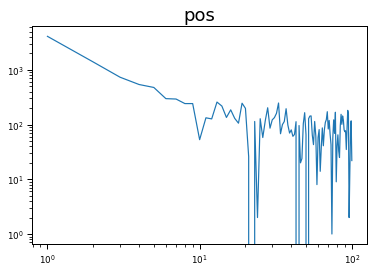

['play', 'checkers', 'big', 'drum', 'big']
['n', 'n', 'adj', 'n', 'adj']
['checkers', 'play', 'big', 'drum', 'drum']
['', 'want', 'sit', 'down', 'bulldozer']


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   21.0s
[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 198 out of 204 | elapsed:  2.2min remaining:    4.0s
[Parallel(n_jobs=-1)]: Done 204 out of 204 | elapsed:  2.2min finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 198 out of 204 | elapsed:  1.9min remaining:    3.5s
[Parallel(n_jobs=-1)]: Done 204 out of 204 | elapsed:  1.9min finished


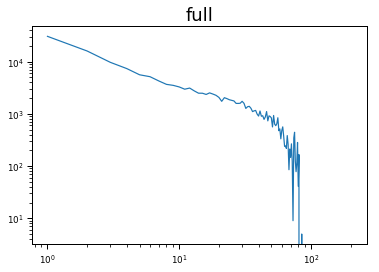

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   20.4s
[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 198 out of 204 | elapsed:  2.1min remaining:    3.9s
[Parallel(n_jobs=-1)]: Done 204 out of 204 | elapsed:  2.2min finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 198 out of 204 | elapsed:  2.0min remaining:    3.7s
[Parallel(n_jobs=-1)]: Done 204 out of 204 | elapsed:  2.0min finished


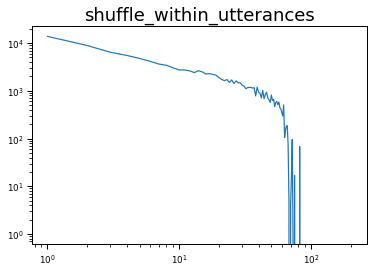

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   24.9s
[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 198 out of 204 | elapsed:  2.9min remaining:    5.2s
[Parallel(n_jobs=-1)]: Done 204 out of 204 | elapsed:  2.9min finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   46.8s
[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 198 out of 204 | elapsed:  1.9min remaining:    3.5s
[Parallel(n_jobs=-1)]: Done 204 out of 204 | elapsed:  1.9min finished


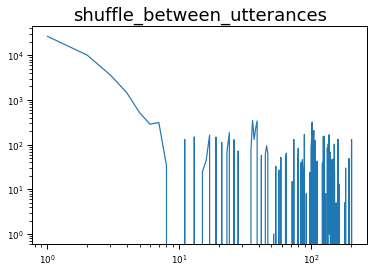

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   20.5s
[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed:  1.6min


KeyboardInterrupt: 

In [34]:
mi_df = pd.DataFrame(
    columns=[
        "MI",
        "MI_var",
        "shuff_MI",
        "shuff_MI_var",
        "distances",
        "age_cohort_low",
        "age_cohort_high",
        "n_words",
        "n_unique_words",
        "top_10_words",
        "shuffling"
    ]
)
# for each age cohort
for (age_cohort_low, age_cohort_high) in tqdm(age_cohorts):
    cohort_subset = transcript_df[
        (transcript_df.age_months / 12 > age_cohort_low)
        & (transcript_df.age_months / 12 <= age_cohort_high)
    ]

    # cohort_words = [[row.PID + "_" + i for i in list(flatten(row.words)) if i not in [None, 'xxx']] for idx, row in cohort_subset.iterrows()]
    cohort_words = [
        [i for i in list(flatten(row.words)) if i not in [None, "xxx"]]
        for idx, row in cohort_subset.iterrows()
    ]
    print(cohort_words[0][:5])

    cohort_pos = [[i for i in np.concatenate(i) if i != ''] for i in cohort_subset.POS.values ]
    print(cohort_pos[0][:5])
    
    shuffled_within_utterance = [
        list(flatten([np.random.permutation([i for i in seq if i not in [None, "xxx"]]) for seq in row.words]))
        for idx, row in cohort_subset.iterrows()
    ]
    print(shuffled_within_utterance[0][:5])
    
    shuffled_between_utterance = [
        list(flatten(np.random.permutation([[i for i in seq if i not in [None, "xxx"]] for seq in row.words])))
        for idx, row in cohort_subset.iterrows()
    ]
    print(shuffled_between_utterance[0][:5])
    
    # no repeats
    cohort_words_no_repeats = [
        remove_repeats([i for i in list(flatten(row.words)) if i not in [None, "xxx"]])
        for idx, row in cohort_subset.iterrows()
    ]
    
    
    # make each phone symbol specific to the transcript
    for transcript_i, (idx, row) in enumerate(cohort_subset.iterrows()):
        cohort_words[transcript_i] = [str(transcript_i) + i for i in cohort_words[transcript_i]]
        shuffled_within_utterance[transcript_i] = [str(transcript_i) + i for i in shuffled_within_utterance[transcript_i]]
        shuffled_between_utterance[transcript_i] = [str(transcript_i) + i for i in shuffled_between_utterance[transcript_i]]
        cohort_words_no_repeats[transcript_i] = [str(transcript_i) + i for i in cohort_words_no_repeats[transcript_i]]
        cohort_pos[transcript_i] = [str(transcript_i) + i for i in cohort_pos[transcript_i]]
    

    n_words = len(np.concatenate(cohort_words))
    n_unique_words = len(np.unique(np.concatenate(cohort_words)))

    # cohort_word_list = np.concatenate([np.concatenate(i) for i in cohort_subset.words.values])
    # most_frequent_words = pd.DataFrame({i:[sum(cohort_word_list == i)] for i in tqdm(np.unique(cohort_word_list))})
    # top_10_words = most_frequent_words.T.sort_values(by=0, ascending=False)[:10].T.columns

    n_unique_words = 0
    top_10_words = 0
    
    
    median_n_words = int(np.median([len(i) for i in cohort_words]))
    distances = np.arange(1, np.max([100, median_n_words]) + 1)
    
    (MI, MI_var), (shuff_MI, shuff_MI_var) = mi.sequential_mutual_information(
        cohort_words, distances=distances, n_jobs=-1, estimate=False
    )
    fig, ax = plt.subplots()
    ax.set_title('full')
    ax.loglog(distances, MI - shuff_MI)
    plt.show()

    mi_df.loc[len(mi_df)] = [
        MI,
        MI_var,
        shuff_MI,
        shuff_MI_var,
        distances,
        age_cohort_low,
        age_cohort_high,
        n_words,
        n_unique_words,
        top_10_words,
        "full"
    ]
    
    (MI, MI_var), (shuff_MI, shuff_MI_var) = mi.sequential_mutual_information(
        shuffled_within_utterance, distances=distances, n_jobs=-1, estimate=False
    )
    fig, ax = plt.subplots()
    ax.loglog(distances, MI - shuff_MI)
    ax.set_title('shuffle_within_utterances')
    plt.show()

    mi_df.loc[len(mi_df)] = [
        MI,
        MI_var,
        shuff_MI,
        shuff_MI_var,
        distances,
        age_cohort_low,
        age_cohort_high,
        n_words,
        n_unique_words,
        top_10_words,
        "shuffle_within_utterances"
    ]
    
    (MI, MI_var), (shuff_MI, shuff_MI_var) = mi.sequential_mutual_information(
        shuffled_between_utterance, distances=distances, n_jobs=-1, estimate=False
    )
    fig, ax = plt.subplots()
    ax.loglog(distances, MI - shuff_MI)
    ax.set_title('shuffle_between_utterances')
    plt.show()

    mi_df.loc[len(mi_df)] = [
        MI,
        MI_var,
        shuff_MI,
        shuff_MI_var,
        distances,
        age_cohort_low,
        age_cohort_high,
        n_words,
        n_unique_words,
        top_10_words,
        "shuffle_between_utterances"
    ]
    
    (MI, MI_var), (shuff_MI, shuff_MI_var) = mi.sequential_mutual_information(
        cohort_words_no_repeats, distances=distances, n_jobs=-1, estimate=False
    )
    fig, ax = plt.subplots()
    ax.loglog(distances, MI - shuff_MI)
    ax.set_title('no_repeats')
    plt.show()

    mi_df.loc[len(mi_df)] = [
        MI,
        MI_var,
        shuff_MI,
        shuff_MI_var,
        distances,
        age_cohort_low,
        age_cohort_high,
        n_words,
        n_unique_words,
        top_10_words,
        "no_repeats"
    ]
    
    (MI, MI_var), (shuff_MI, shuff_MI_var) = mi.sequential_mutual_information(
        cohort_pos, distances=distances, n_jobs=-1, estimate=False
    )
    fig, ax = plt.subplots()
    ax.loglog(distances, MI - shuff_MI)
    ax.set_title('pos')
    plt.show()

    mi_df.loc[len(mi_df)] = [
        MI,
        MI_var,
        shuff_MI,
        shuff_MI_var,
        distances,
        age_cohort_low,
        age_cohort_high,
        n_words,
        n_unique_words,
        top_10_words,
        "pos"
    ]

In [86]:
mi_df[:3]

,MI,MI_var,shuff_MI,shuff_MI_var,distances,age_cohort_low,age_cohort_high,n_words,n_unique_words,top_10_words,shuffling
0,"[7.429585944350688, 7.061895994412737, 6.87565...","[0.018909504872015814, 0.018724386000222765, 0...","[6.522452604365126, 6.522404371043072, 6.52627...","[0.018386201936750897, 0.018422906440596243, 0...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",1,1.5,15154,0,0,full
1,"[7.283136119755314, 7.005534229983473, 6.87360...","[0.018813410775130723, 0.01870092255956759, 0....","[6.531399340583583, 6.533150401709976, 6.51950...","[0.01839123228399068, 0.018440118944123222, 0....","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",1,1.5,15154,0,0,shuffle_within_sentences
2,"[7.052630620598375, 6.669329390617843, 6.58815...","[0.018675270671107073, 0.01853327956259101, 0....","[6.524365813575219, 6.531560878020596, 6.53362...","[0.01837163907209805, 0.018436910133882302, 0....","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",1,1.5,15154,0,0,shuffle_between_sentences


In [87]:
#mi_df.to_pickle(DATA_DIR / "mi" / "childes_mi_with_shuffling_median_no_estimate.pickle")

In [1]:
for shuff in ['full', 'shuffle_within_utterances', 'shuffle_between_utterances', 'no_repeats', 'pos']:
    print(shuff)
    fig, axs = plt.subplots(ncols=len(age_cohorts), figsize=(4*len(age_cohorts),4))
    for idx, row in mi_df.iterrows():
        if row.shuffling != shuff: 
            continue
        MI = row.MI-row.shuff_MI
        MI_var = row.MI_var
        #ax.scatter(distances, row.MI-row.shuff_MI)
        ax = axs[np.array([i[0] for i in age_cohorts]) == row.age_cohort_low][0]
        #ax.plot(distances, row.MI-row.shuff_MI, label = '{}-{} years'.format(row.age_cohort_low, row.age_cohort_high), lw=3)
        ax.scatter(row.distances, row.MI-row.shuff_MI, s=10, color='k')
        ax.fill_between(row.distances, MI-MI_var, MI+MI_var, alpha = 0.25, color= 'k')
        #ax.legend()
        ax.set_title('{}-{} years'.format(row.age_cohort_low, row.age_cohort_high))
        ax.set_ylim([1e-3,5])
        #ax.set_xlim([1, 100])

        ax.set_yscale('log')
        ax.set_xscale('log')
    plt.show()

full


NameError: name 'plt' is not defined